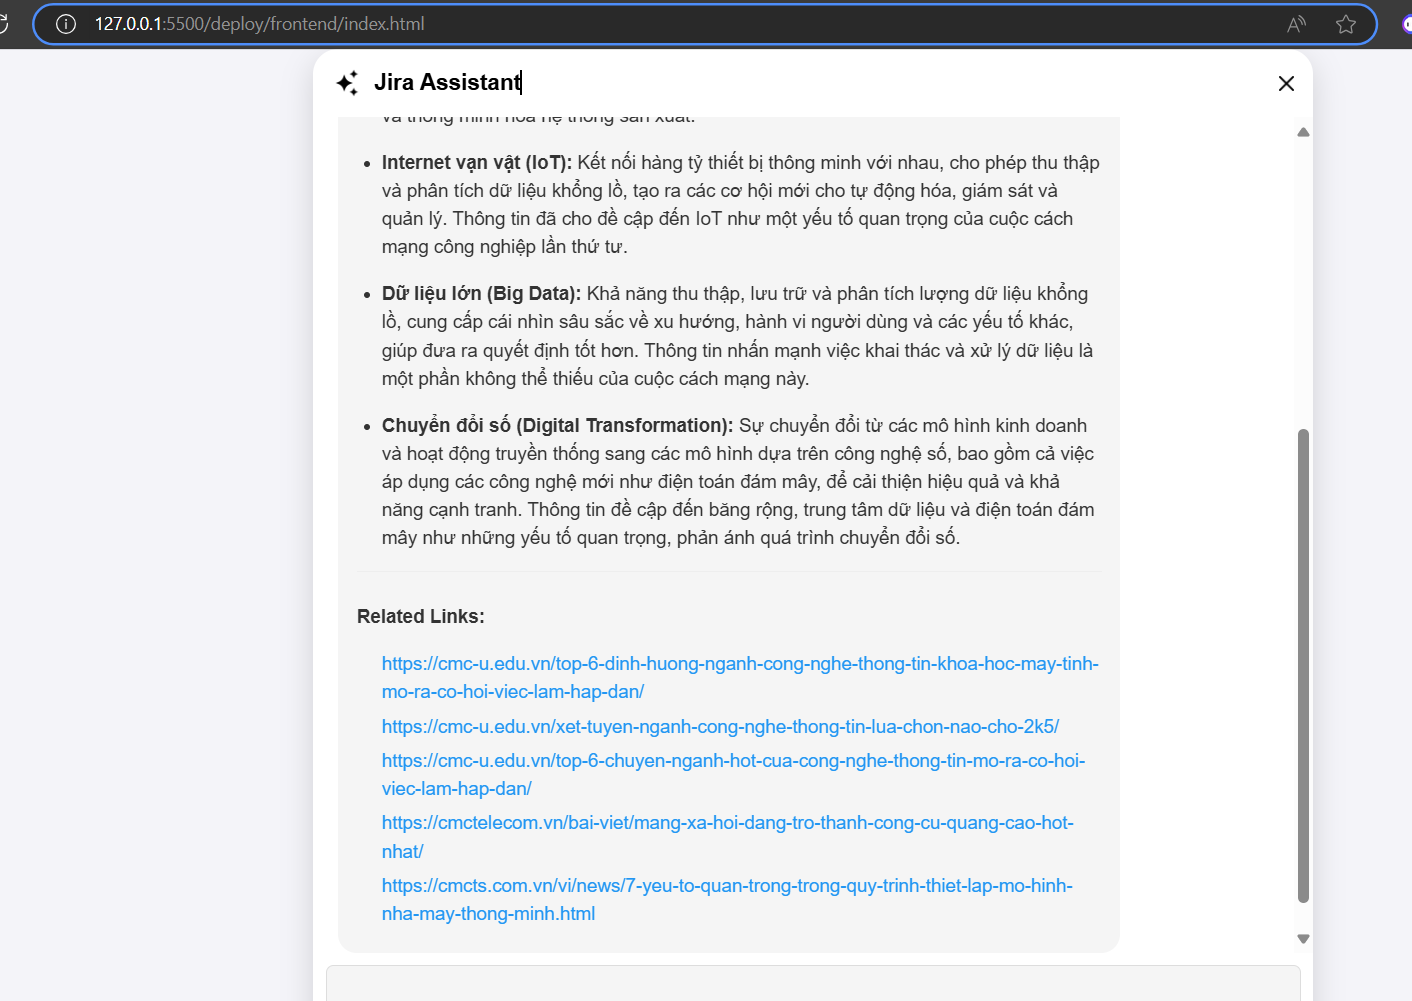

Hãy kiểm tra luồng xử lý response và links:

1. Backend đang gửi cả response và links:
```python:deploy/backend/app.py
@app.route('/send_message', methods=['POST'])
def chat():
    try:
        response, extracted_links = qa_chain.run(question)
        return jsonify({
            "response": response,
            "links": extracted_links
        })
    except Exception as e:
        logger.error(f"Error processing question: {str(e)}")
        return jsonify({"error": "Internal server error"}), 500
```

2. Frontend đang chỉ hiển thị response, chưa xử lý links:
```javascript:deploy/frontend/script.js
async function sendMessage(message) {
    if (!message) return;
    displayMessage(message, 'user');

    try {
        const response = await fetch(`http://localhost:3000/send_message`, {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json'
            },
            body: JSON.stringify({
                question: message
            })
        });

        const data = await response.json();
        displayMessage(data.response, 'bot'); // Chỉ hiển thị response, bỏ qua links
    } catch (error) {
        console.error('Error:', error);
        displayMessage('Xin lỗi, có lỗi xảy ra', 'bot');
    }
}
```

Để hiển thị cả links, cần sửa lại hàm displayMessage:

```javascript:deploy/frontend/script.js
function displayMessage(content, sender) {
    const messageDiv = document.createElement('div');
    messageDiv.className = `message ${sender}`;
    
    if (typeof content === 'string') {
        // Nếu content là string (message từ user hoặc response đơn thuần)
        messageDiv.innerHTML = marked.parse(content);
    } else if (typeof content === 'object') {
        // Nếu content là object có response và links
        let messageContent = marked.parse(content.response);
        
        // Thêm phần links nếu có
        if (content.links && content.links.length > 0) {
            messageContent += '<div class="message-links">';
            messageContent += '<p><strong>Related Links:</strong></p>';
            messageContent += '<ul>';
            content.links.forEach(link => {
                messageContent += `<li><a href="${link}" target="_blank">${link}</a></li>`;
            });
            messageContent += '</ul>';
            messageContent += '</div>';
        }
        
        messageDiv.innerHTML = messageContent;
    }
    
    chatWindow.appendChild(messageDiv);
    chatWindow.scrollTop = chatWindow.scrollHeight;
}

async function sendMessage(message) {
    if (!message) return;
    displayMessage(message, 'user');

    try {
        const response = await fetch(`http://localhost:3000/send_message`, {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json'
            },
            body: JSON.stringify({
                question: message
            })
        });

        const data = await response.json();
        // Gửi cả object chứa response và links
        displayMessage({
            response: data.response,
            links: data.links
        }, 'bot');
    } catch (error) {
        console.error('Error:', error);
        displayMessage('Xin lỗi, có lỗi xảy ra', 'bot');
    }
}
```

Thêm CSS cho phần hiển thị links:

```css:deploy/frontend/style.css
.message-links {
    margin-top: 10px;
    padding-top: 10px;
    border-top: 1px solid #eee;
}

.message-links ul {
    list-style: none;
    padding-left: 0;
}

.message-links li {
    margin: 5px 0;
}

.message-links a {
    color: #0366d6;
    text-decoration: none;
}

.message-links a:hover {
    text-decoration: underline;
}
```

Với những thay đổi này:
1. Backend vẫn gửi cả response và links
2. Frontend sẽ nhận và hiển thị cả hai
3. Links sẽ được hiển thị dưới phần response với định dạng riêng
4. Người dùng có thể click vào links để mở trong tab mới
